### Day 2 - RGB to grayscale

In [1]:
import numpy as np
from PIL import Image

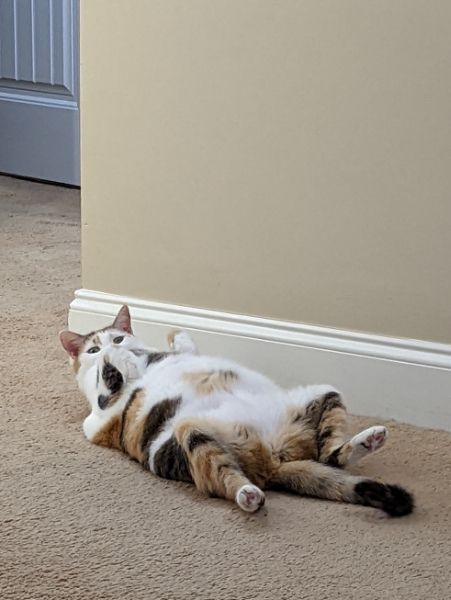

In [2]:
image = Image.open("../cat-1.jpg")
image

In [3]:
# Convert PIL Image to numpy array
img_array = np.array(image)
print(f"Image shape: {img_array.shape}")

height = img_array.shape[0]
width = img_array.shape[1]

Image shape: (600, 451, 3)


In [4]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
cuda.init()

device = cuda.Device(0)

print(f"Cuda version: {".".join([str(i) for i in cuda.get_version()])}")
print(f"Device:\t{device.name()}")

Cuda version: 12.8.0
Device:	NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
BLOCK_SIZE_X = 32
BLOCK_SIZE_Y = 32

try:
    ctx = device.make_context()

    mod = SourceModule(
        """
            #include <stdint.h>

            __global__ void rgb2gray(uint8_t *in, uint8_t *out, uint32_t w, uint32_t h)
            {

                int x = blockIdx.x * blockDim.x + threadIdx.x;
                int y = blockIdx.y * blockDim.y + threadIdx.y;

                if (x < w && y < h) {
                    int idx = (y * w + x);

                    uint8_t r = in[idx * 3    ];
                    uint8_t g = in[idx * 3 + 1];
                    uint8_t b = in[idx * 3 + 2];

                    out[idx] = 0.21 * r + 0.72*g + 0.07*b;
                }
            }
        """)

    rgb2gray = mod.get_function("rgb2gray")

    gpu_array = cuda.mem_alloc_like(img_array)
    gpu_gray_array = cuda.mem_alloc(width * height)

    cuda.memcpy_htod(gpu_array, img_array)

    block_size = (BLOCK_SIZE_X, BLOCK_SIZE_Y, 1)
    grid_size = (
        ((width + BLOCK_SIZE_X - 1) // BLOCK_SIZE_X),
        ((height + BLOCK_SIZE_Y - 1) // BLOCK_SIZE_Y),
        1
    )

    rgb2gray(gpu_array, gpu_gray_array, np.uint32(width), np.uint32(height), block=block_size, grid=grid_size)

    cpu_gray_array = np.empty(shape=(height, width), dtype=np.uint8)
    cuda.memcpy_dtoh(cpu_gray_array, gpu_gray_array)


finally:
    ctx.pop()
    ctx.detach()

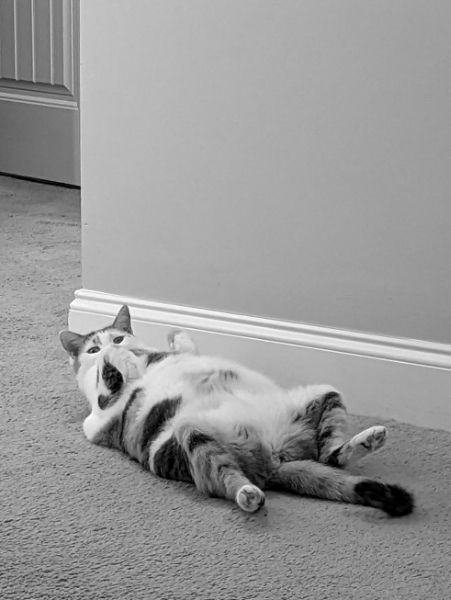

In [6]:
Image.fromarray(cpu_gray_array, mode='L')

### Looks good to me